# Red Giant Mode fitting

Fitting $nstars$ RG stars chosen at random using Vrard model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
import random

In [2]:
#import output data
nstars = 50
IDs = []
stardat = pd.read_csv('RGdata/output_1000stars.csv', delim_whitespace=False, header=0, usecols=range(1,4))
for i in range(nstars):
    IDs.append(random.choice(stardat['ID']))

modes = {} # dictionary with frequencies and errors
for i in IDs:
    modes[str(i)] = pd.read_csv('RGdata/modes_'+str(i)+'.csv', delim_whitespace=False, header=0, usecols=[0,7])
    modes[str(i)] = modes[str(i)].sort_values(by=['f0'])
    modes[str(i)] = modes[str(i)].set_index(np.arange(0,len(modes[str(i)]),1))
    modes[str(i)]['dnu'] = modes[str(i)].f0.diff(2).shift(-1)/2
    dnu_avg = np.mean(modes[str(i)].dnu)
    n_min = int(modes[str(i)].f0.min() / dnu_avg)
    n_obs = np.arange(n_min, n_min+len(modes[str(i)].f0), 1)
    modes[str(i)]['n'] = n_obs
    
stardat= stardat.loc[stardat['ID'].isin(IDs)]

The model used will be that described in Vrard 2014:

$$\nu(n)=\left(n+\epsilon+\frac{\alpha}{2}\left(n_{max}-n\right)^2+\frac{\mathcal{A}\mathcal{G}}{2\pi}sin\left(\frac{2\pi\left(n-n_{max}\right)}{\mathcal{G}}+\phi\right)\right) \langle\Delta\nu\rangle$$

where is found from $n_{max}= \nu_{max}/\Delta\nu - \epsilon$

In [3]:
def echelle(stardat, modes, ID, model=False, stanfit=[], stan_dnu=0):
    numax_obs = float(stardat.loc[stardat['ID'] == ID].Numax)
    numax_obs_err = float(stardat.loc[stardat['ID'] == ID].Numax_err)
    #dnu_obs = float(stardat.loc[stardat.ID == IDs[i]].Dnu_median_all)
    #dnu_obs = np.mean(np.diff(modes[str(IDs[i])].f0)) 
    dnu_obs = np.mean(modes[str(ID)].f0.diff(2).shift(-1)/2)
    # Create dataframes for frequencies and calculate orders n
    l0modes = pd.DataFrame([modes[str(ID)].f0, modes[str(ID)].f0_err])
    l0modes = l0modes.T
    l0modes = l0modes.sort_values('f0', ascending=True)
    n_min = int(l0modes.f0.min() / dnu_obs)
    n_obs = np.arange(n_min, n_min+len(l0modes.f0), 1)
    l0modes['n'] = n_obs
    l0modes = l0modes.set_index(np.arange(0, len(l0modes.f0), 1))
    plt.scatter(l0modes.f0 % dnu_obs, l0modes.f0, label = str(ID))
    
    if model:
        label = 'Stan Fit '+str(ID)
        plt.plot(stanfit % stan_dnu, stanfit, label = label)
        
    plt.xlabel(r'Frequency modulo ($\mu Hz$)')
    plt.ylabel(r'Frequency ($\mu Hz$)')
    plt.legend()

In [24]:
def model(n, dnu, nmax, epsilon, alpha, A, G, phi, tau):
    freqs = (n + epsilon + alpha/2 * (nmax - n)**2 + A*G/(2*np.pi) * np.sin((2*np.pi*(n-nmax))/G + phi))*dnu* np.exp(-n/tau);
    return freqs

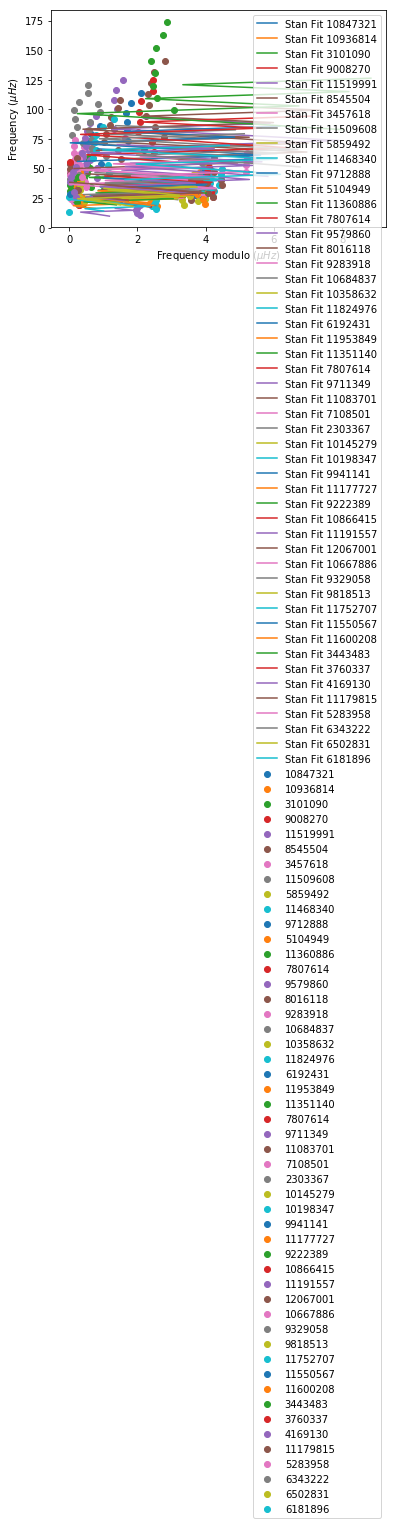

In [27]:
for i in IDs:
    #values from Vrard
    dnu_avg = np.mean(modes[str(i)].dnu)
    n = modes[str(i)].n
    #epsilon = 0.601 + 0.632*np.log(dnu_avg)
    epsilon = np.median((modes[str(i)].f0 % dnu_avg) / dnu_avg)
    numax_obs = float(stardat.loc[stardat['ID'] == i].Numax)
    nmax = numax_obs/dnu_avg - epsilon
    alpha = 0.015*dnu_avg**(-0.32)
    A = 0.06*dnu_avg**(-0.88) 
    G = 3.08
    tau = 50
    phi = 1.71
    f = model(n, dnu_avg, nmax, epsilon, alpha, A, G, phi, tau)
    echelle(stardat, modes, i, True, f, dnu_avg)
    

In [6]:
'''plt.scatter(l0modes.f0 % dnu_obs, l0modes.f0, label = 'Data') 
plt.plot(f % dnu_obs, f, label = 'Model')
plt.xlabel(r'Frequency modulo ($\mu Hz$)')
plt.ylabel(r'Frequency ($\mu Hz$)')
#mod_err = (l0modes.f0 % dnu_obs)*np.sqrt((dnu_obs_err/dnu_obs)**2 + (l0modes.f0_err/l0modes.f0)**2)
plt.errorbar(l0modes.f0 % dnu_obs, l0modes.f0, yerr = l0modes.f0_err, xerr = mod_err, ecolor = 'r', ls='none', label = 'Error')
plt.legend()'''

"plt.scatter(l0modes.f0 % dnu_obs, l0modes.f0, label = 'Data') \nplt.plot(f % dnu_obs, f, label = 'Model')\nplt.xlabel(r'Frequency modulo ($\\mu Hz$)')\nplt.ylabel(r'Frequency ($\\mu Hz$)')\n#mod_err = (l0modes.f0 % dnu_obs)*np.sqrt((dnu_obs_err/dnu_obs)**2 + (l0modes.f0_err/l0modes.f0)**2)\nplt.errorbar(l0modes.f0 % dnu_obs, l0modes.f0, yerr = l0modes.f0_err, xerr = mod_err, ecolor = 'r', ls='none', label = 'Error')\nplt.legend()"

In [14]:
code = '''
data {
    int N;
    real n[N];
    real freq[N];
    real freq_err[N];
    real dnu_guess;
}
parameters {
    real dnu;
    real nmax;
    real epsilon;
    real alpha;
    real<lower = 0> A;
    real<lower = 0> G;
    real<lower = -2.0*pi(), upper = 2.0*pi()> phi;
    real<lower = 0> tau;
    real epsA;
    real epsB;
    real alA;
    real alB;
    real AA;
    real AB;
    
}
model {
    real mod[N];
    for (i in 1:N){
        mod[i] = (n[i] + epsilon + (alpha/2) * (nmax - n[i])^2 + 
            A*G/(2*pi()) * sin((2*pi()*(n[i]-nmax))/G + phi))*dnu*exp(-n[i]/tau);
    }
    mod ~ normal(freq, freq_err);
    dnu ~ normal(dnu_guess, dnu_guess*0.001);
    epsilon ~ normal(epsA + epsB*log(dnu), 0.5);
    epsilon ~ uniform(-1.0, 2.0);
    nmax ~ normal(10, 4);
    alpha ~ lognormal(log(alA*dnu^(-alB)), 0.3);
    //alpha ~ lognormal(log(0.015*dnu^(-0.32)), 0.3);
    A ~ lognormal(log(AA*dnu^(-AB)), 0.4);
    //A ~ lognormal(log(0.06*dnu^(-0.88)), 0.4);
    G ~ normal(3.08, 0.65);
    tau ~ normal(50, 10);
    epsA ~ normal(0.601, 0.080);
    epsB ~ normal(0.632, 0.080);
    alA ~ normal(0.015, 0.005);
    alB ~ normal(0.32, 0.08);
    AA ~ normal(0.06, 0.01);
    AB ~ normal(0.88, 0.05);
}
generated quantities{
    real fm[N];
    for (j in 1:N){
        fm[j] = (n[j] + epsilon + (alpha/2) * (nmax - n[j])^2 + 
            A*G/(2*pi()) * sin((2*pi()*(n[j]-nmax))/G + phi))*dnu*exp(-n[i]/tau);
        }
}
'''
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3b8b9512631b376acf47681c72b4c4ca NOW.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2_/b8v0t8pn1hj1p3r4lyfvvv2h0000gn/T/tmp_6fwecjf/stanfit4anon_model_3b8b9512631b376acf47681c72b4c4ca_4464433443721915092.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [18]:
fits = {}
for i in IDs:
    dat_star = stardat.loc[stardat['ID'] == i]
    df_star = modes[str(i)]
    df_star = df_star.sort_values(by=['f0'])
    dnu_obs = np.mean(df_star.dnu)
    numax_obs = float(dat_star.loc[dat_star['ID'] == i].Numax)
    df_star = df_star.set_index(np.arange(0, len(df_star.f0), 1))
    nmax_guess = np.mean(df_star.n)
    epsilon_obs = np.median((df_star.f0 % dnu_obs) / dnu_obs)
    #epsilon_obs = 0.601 + 0.632*np.log(dnu_obs)
    alpha_obs = 0.015*dnu_obs**(-0.32)
    A_obs = 0.06*dnu_obs**(-0.88)
    
    data = {'N': len(df_star.f0), 'n': df_star.n.values, 'freq': df_star.f0.values,
            'freq_err': df_star.f0_err.values, 'dnu_guess': dnu_obs}
    start = {'dnu': dnu_obs, 'epsilon': epsilon_obs, 
             'nmax': numax_obs/dnu_obs - epsilon_obs, 'alpha': alpha_obs, 'A': A_obs,
             'G': 3, 'phi': 1.6}
    nchains=4
    fit = sm.sampling(data=data, iter=5000, chains=nchains, init=[start for n in range(nchains)])
    fits[str(i)] = fit
    output = pd.DataFrame({'dnu': fit['dnu'], 'nmax': fit['nmax'], 'epsilon': fit['epsilon'], 
                           'alpha': fit['alpha'], 'A': fit['A'], 'G': fit['G'], 'phi': fit['phi'], 'tau': fit['tau'], 
                           'epsA': fit['epsA'], 'epsB': fit['epsB'], 'alA': fit['alA'], 'alB': fit['alB'],
                           'AA': fit['AA'], 'AB': fit['AB']})
    #output.to_csv('samples_' + str(i) + '.csv')

In [19]:
for i in IDs:
    print('ID = ' + str(i))
    print(fits[str(i)])

ID = 10847321
Inference for Stan model: anon_model_3b8b9512631b376acf47681c72b4c4ca.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       6.48    0.11   0.15   6.22   6.46   6.56   6.57   6.58      2  16.73
nmax      7.03    3.15   4.46   3.88   4.17    4.6  10.67  14.74      2  28.01
epsilon   0.81    0.06    0.1   0.65   0.73    0.8    0.9   0.98      3   1.73
alpha     0.04    0.02   0.02 5.6e-7   0.02   0.05   0.06   0.07      2   4.91
A         0.02  5.2e-3 7.9e-3 8.6e-3   0.01   0.02   0.03   0.03      2   2.62
G         3.37    0.44   0.64   2.64   2.77    3.6   3.71    4.5      2   5.93
phi      -3.03    3.35   4.75  -6.25  -6.06  -5.72   1.88   5.16      2  12.72
tau     201.98  159.96 228.23  56.19  68.07  75.06 114.83 606.26      2   7.58
epsA      0.65    0.09   0.14   0.43   0.54   0.61   0.86   0.86      2   2.17
epsB  

Inference for Stan model: anon_model_3b8b9512631b376acf47681c72b4c4ca.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       9.21  7.9e-3   0.01   9.18    9.2    9.2   9.22   9.22      2    2.8
nmax      9.62    2.61    3.7    3.0   7.34  11.66  11.84  11.95      2  45.61
epsilon   0.53    0.18   0.25   0.27   0.28   0.47   0.77   0.84      2  11.71
alpha     0.03  8.5e-3   0.01   0.01   0.02   0.03   0.03   0.05      2    4.6
A      10.0e-3  1.9e-3 2.9e-3 8.3e-3 8.3e-3 8.5e-3 8.5e-3   0.02      2   2.31
G         2.94    0.47   0.67   2.14   2.37   2.82   3.25    4.2      2   7.84
phi      -0.63    2.11   2.99  -6.23  -1.57   0.81   1.44   1.61      2  12.45
tau      19.93   20.79  29.64   2.44   2.79   3.17  26.39  81.31      2   7.75
epsA      0.16    0.31   0.44  -0.56  -0.21   0.26   0.41   0.68      2  11.58
epsB      0.67    0.

Inference for Stan model: anon_model_3b8b9512631b376acf47681c72b4c4ca.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       4.53  5.3e-5 4.5e-3   4.52   4.53   4.53   4.53   4.54   7157    1.0
nmax       3.3  7.2e-3   0.42   2.46   3.02    3.3   3.57   4.14   3466    1.0
epsilon   0.44  1.2e-3   0.07    0.3   0.39   0.44   0.48   0.58   3452    1.0
alpha     0.05  1.1e-4 7.1e-3   0.04   0.05   0.05   0.06   0.07   4372    1.0
A         0.02  1.1e-4 5.7e-3 9.2e-3   0.02   0.02   0.02   0.03   2593    1.0
G          3.5  7.9e-3   0.42   2.82   3.19   3.46   3.76   4.44   2819    1.0
phi      -3.86    0.03   1.44  -6.09   -5.0  -4.01  -2.85  -0.81   2189    1.0
tau      66.86    0.11   8.23  51.17  61.31  66.72   72.3  83.74   6016    1.0
epsA      0.58  1.5e-3   0.08   0.42   0.52   0.58   0.63   0.73   2688   1.01
epsB      0.59  1.4e

Inference for Stan model: anon_model_3b8b9512631b376acf47681c72b4c4ca.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       3.79  3.5e-5 3.8e-3   3.78   3.79   3.79   3.79    3.8  11858    1.0
nmax      2.53    0.02   0.45   1.53   2.27   2.57   2.84   3.33    534   1.01
epsilon   0.33  1.5e-3   0.06    0.2   0.29   0.33   0.36   0.42   1463    1.0
alpha     0.05  1.1e-4 6.9e-3   0.04   0.04   0.05   0.05   0.06   3936    1.0
A         0.03  3.9e-4 7.0e-3   0.01   0.02   0.03   0.03   0.04    328   1.01
G         3.63    0.04   0.46    2.9   3.32   3.58   3.89   4.73    125   1.03
phi       -2.9    1.66   2.77  -6.02  -4.68  -3.97  -2.81   3.01      3   2.02
tau      67.07    0.16    8.2   51.0  61.69  66.86  72.41  83.75   2638    1.0
epsA      0.58  8.5e-4   0.08   0.42   0.52   0.58   0.63   0.73   8727    1.0
epsB       0.6  8.5e

Inference for Stan model: anon_model_3b8b9512631b376acf47681c72b4c4ca.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       7.07  6.9e-5 7.1e-3   7.05   7.06   7.07   7.07   7.08  10667    1.0
nmax      4.07    0.04   0.22   3.66   3.92   4.06   4.22   4.52     26   1.05
epsilon   0.76  1.3e-3   0.07   0.65   0.72   0.76    0.8   0.92   2823   1.01
alpha     0.05  1.3e-4 6.4e-3   0.04   0.05   0.05   0.05   0.06   2577    1.0
A         0.02  2.5e-3 6.3e-3   0.01   0.02   0.02   0.02   0.04      7   1.19
G         3.74    0.18   0.33   2.99   3.58   3.78   3.95   4.33      3   1.56
phi      -4.76    1.14   1.74  -6.26  -6.03  -5.59   -3.9   -0.6      2   2.53
tau      69.56    0.18   8.31  53.77  63.88  69.38  74.95  86.38   2025   1.01
epsA      0.58  8.6e-4   0.08   0.42   0.52   0.58   0.63   0.74   8899    1.0
epsB      0.59  8.0e

Inference for Stan model: anon_model_3b8b9512631b376acf47681c72b4c4ca.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       4.21  3.4e-5 4.3e-3    4.2    4.2   4.21   4.21   4.22  15711    1.0
nmax      2.45    0.38   0.69   1.14   1.98    2.4   2.97   3.68      3    1.6
epsilon   0.34    0.05   0.09   0.18   0.29   0.34   0.41    0.5      3   1.53
alpha     0.05  1.8e-3 6.9e-3   0.03   0.04   0.05   0.05   0.06     15   1.09
A         0.03  4.4e-3   0.01   0.01   0.02   0.03   0.04   0.05      5   1.27
G         3.75     0.5   0.77   2.83   3.17   3.46   4.31   5.44      2   2.42
phi      -4.35    1.62   2.38  -6.26  -6.03  -5.58  -3.03   0.89      2   3.36
tau      69.25    0.96    8.4  53.29  63.53   69.1  74.82  86.09     76   1.03
epsA      0.57  6.6e-4   0.08   0.42   0.52   0.57   0.62   0.72  13854    1.0
epsB      0.59  7.1e

Inference for Stan model: anon_model_3b8b9512631b376acf47681c72b4c4ca.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       3.89  3.3e-5 3.9e-3   3.88   3.89   3.89   3.89    3.9  13578    1.0
nmax      3.42    0.12    0.3   2.81   3.21   3.44   3.63   3.97      7   1.19
epsilon   1.29  1.9e-3   0.04   1.22   1.26   1.29   1.32   1.38    460   1.02
alpha     0.06  1.1e-4 6.7e-3   0.05   0.06   0.06   0.07   0.08   3668   1.01
A         0.02  1.2e-4 6.2e-3   0.01   0.02   0.02   0.03   0.03   2465   1.01
G         3.22     0.2   0.48   2.35   2.89   3.24   3.55   4.14      6   1.25
phi       -3.4    1.51   2.41  -6.23  -5.64  -4.15  -1.25   1.17      3    2.1
tau      67.89    0.65   8.26  52.18  62.08  67.74  73.51  84.53    161   1.02
epsA       0.6  7.6e-4   0.08   0.44   0.54    0.6   0.65   0.75  10884    1.0
epsB      0.63  8.5e

Inference for Stan model: anon_model_3b8b9512631b376acf47681c72b4c4ca.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       4.44  3.6e-5 4.4e-3   4.43   4.44   4.44   4.44   4.45  14911    1.0
nmax      2.22    0.03   1.01  -0.09   1.67   2.36   2.92   3.79    900   1.01
epsilon   1.24  4.4e-3   0.13   0.94   1.17   1.26   1.33   1.46    931   1.01
alpha     0.05  2.2e-4   0.01   0.03   0.04   0.05   0.06   0.07   2043    1.0
A         0.02  1.1e-4 8.8e-3 7.5e-3   0.01   0.02   0.03   0.04   5900    1.0
G         3.28    0.02   0.65   1.99   2.84   3.29   3.72   4.52   1270    1.0
phi      -0.38    0.24   3.66  -5.98  -3.69  -0.46    2.7   5.97    242   1.01
tau      67.29    0.09   8.05  51.77  61.78  67.26  72.65  83.52   8858    1.0
epsA       0.6  7.5e-4   0.08   0.44   0.54    0.6   0.65   0.75  10764    1.0
epsB      0.62  7.4e

Inference for Stan model: anon_model_3b8b9512631b376acf47681c72b4c4ca.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       8.72  4.3e-4 6.1e-4   8.72   8.72   8.72   8.72   8.72      2 783.14
nmax      10.5    0.39   0.55   9.66  10.02   10.6  10.96  11.16      2  6.4e5
epsilon   0.98    0.43   0.61   0.26   0.37   0.96   1.59   1.72      2  7.7e5
alpha   9.8e-3  3.6e-3 5.1e-3 2.6e-3 4.8e-3   0.01   0.01   0.01      2 5320.2
A       7.8e-3  1.5e-3 2.1e-3 4.8e-3 5.8e-3 7.9e-3 9.7e-3   0.01      2  2.6e5
G          2.5    0.22   0.31   2.23   2.25   2.38   2.77    3.0      2  1.5e5
phi       0.42    0.81   1.14  -1.43  -0.57   0.75   1.35   1.61      2  4.9e5
tau       2.47    0.08   0.23   2.07   2.27   2.46   2.66   2.89      9   2.16
epsA      0.91     0.4   0.56   0.55   0.56    0.6   1.31   1.88      2  6.4e5
epsB      0.67    0.

Inference for Stan model: anon_model_3b8b9512631b376acf47681c72b4c4ca.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       3.82  3.4e-5 3.8e-3   3.81   3.82   3.82   3.82   3.83  12663    1.0
nmax      2.68  4.0e-3   0.29   2.09   2.49   2.68   2.88   3.25   5305    1.0
epsilon    1.3  7.0e-4   0.04   1.21   1.27   1.29   1.32   1.38   3934    1.0
alpha     0.05  1.1e-4 6.7e-3   0.04   0.05   0.05   0.06   0.07   3604    1.0
A         0.03  5.7e-5 5.0e-3   0.02   0.03   0.03   0.03   0.04   7791    1.0
G         4.29  4.4e-3   0.36   3.67   4.04   4.27   4.52   5.05   6472    1.0
phi      -1.55    0.01   0.74  -2.97  -2.05  -1.55  -1.04  -0.08   5128    1.0
tau      66.48    0.13   8.29  50.53  60.89  66.23  71.98  83.18   4140    1.0
epsA       0.6  7.7e-4   0.08   0.44   0.54    0.6   0.65   0.75  10416    1.0
epsB      0.63  8.0e

Inference for Stan model: anon_model_3b8b9512631b376acf47681c72b4c4ca.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu      10.67  3.6e-3 7.3e-3  10.66  10.66  10.66  10.67  10.69      4    1.4
nmax      9.93    2.06   2.91    4.7   7.96  11.22  11.96  12.32      2  31.81
epsilon   1.49    0.21   0.29   1.01   1.43   1.46   1.73   1.93      2   8.11
alpha     0.02    0.02   0.02 2.1e-3 2.4e-3 4.7e-3   0.03   0.06      2   7.31
A         0.01  3.7e-3 5.3e-3 5.1e-3 8.6e-3   0.01   0.01   0.02      2   5.46
G         4.46    0.75   1.06   3.06   3.58   4.39   5.05   6.27      2  11.73
phi       1.73     3.3   4.67  -6.26  -1.52   3.59   5.31   5.84      2  54.72
tau       19.9   21.31  30.42   2.13   2.39   2.65   26.9  83.61      2   7.52
epsA       0.6    0.03   0.06   0.48   0.54   0.62   0.66   0.68      4   1.53
epsB      0.66    0.

Inference for Stan model: anon_model_3b8b9512631b376acf47681c72b4c4ca.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       5.26  4.3e-5 5.2e-3   5.25   5.26   5.26   5.26   5.27  14646    1.0
nmax      4.12    0.06   0.39   3.33   3.87   4.13   4.39   4.88     36   1.05
epsilon   0.66  4.5e-3   0.09    0.5    0.6   0.66   0.72   0.85    384   1.02
alpha     0.06  1.3e-4 7.9e-3   0.04   0.05   0.06   0.06   0.08   3445    1.0
A         0.02  2.8e-4 7.7e-3 8.1e-3   0.01   0.02   0.02   0.04    764   1.01
G         3.13    0.14   0.53   2.29   2.76   3.06   3.45   4.33     13   1.12
phi      -1.21    1.85    3.8  -6.14  -4.66  -1.97   1.86    5.9      4   1.64
tau      65.88    0.14   8.46  49.37  60.19  65.79  71.58  82.79   3920    1.0
epsA      0.58  6.7e-4   0.08   0.43   0.52   0.58   0.63   0.73  13276    1.0
epsB      0.59  6.6e

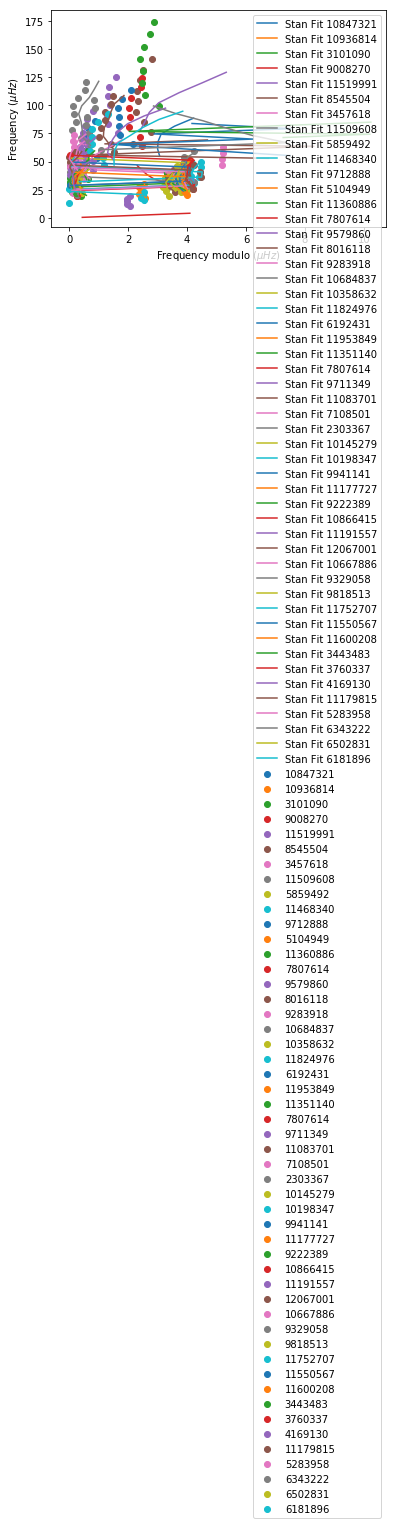

In [29]:
for i in IDs:
    stanfit = model(modes[str(i)].n, fits[str(i)]['dnu'].mean(), fits[str(i)]['nmax'].mean(), fits[str(i)]['epsilon'].mean(), fits[str(i)]['alpha'].mean(), fits[str(i)]['A'].mean(), fits[str(i)]['G'].mean(), fits[str(i)]['phi'].mean(), fits[str(i)]['tau'].mean())
    stan_dnu = fits[str(i)]['dnu'].mean()
    echelle(stardat, modes, i, True, stanfit, stan_dnu)

Text(0.5, 0.98, 'Parameters plotted against $\\langle \\Delta \\nu \\rangle$')

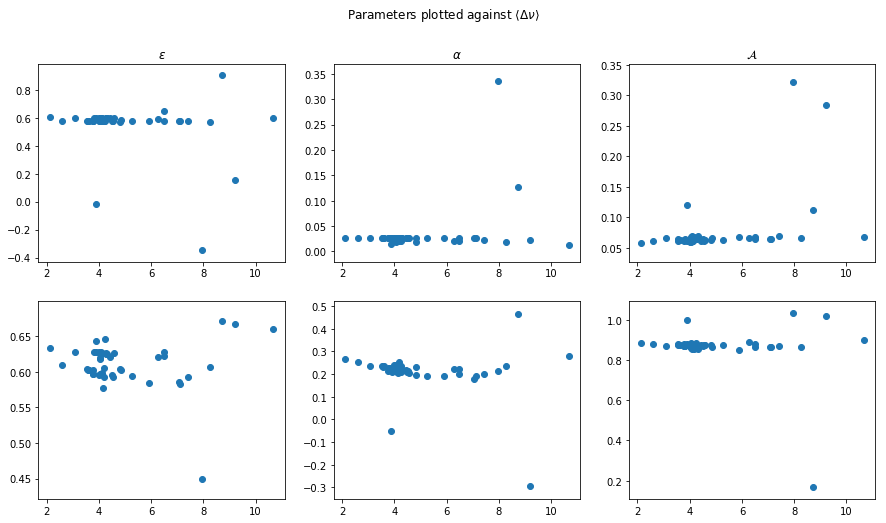

In [30]:
dnus = []
epsAs = []
epsBs = []
alAs = []
alBs = []
AAs = []
ABs = []
for i in IDs:
    dnus.append(fits[str(i)]['dnu'].mean())
    epsAs.append(fits[str(i)]['epsA'].mean())
    epsBs.append(fits[str(i)]['epsB'].mean())
    alAs.append(fits[str(i)]['alA'].mean())
    alBs.append(fits[str(i)]['alB'].mean())
    AAs.append(fits[str(i)]['AA'].mean())
    ABs.append(fits[str(i)]['AB'].mean())
    
fig, axs = plt.subplots(2, 3, figsize=(15, 8), sharey=False)
axs[0,0].scatter(dnus, epsAs)
axs[0,0].set_title(r'$\epsilon$')
axs[1,0].scatter(dnus, epsBs)
#axs[1,0].set_title(r'$\alpha$')
axs[0,1].scatter(dnus, alAs)
axs[0,1].set_title(r'$\alpha$')
axs[1,1].scatter(dnus, alBs)
#axs[1,1].set_title(r'$\mathcal{G}$')
axs[0,2].scatter(dnus, AAs)
axs[0,2].set_title(r'$\mathcal{A}$')
axs[1,2].scatter(dnus, ABs)
#axs[1,2].set_title(r'$\mathcal{G}$')
fig.suptitle(r'Parameters plotted against $\langle \Delta \nu \rangle$')

Text(0.5, 0.98, 'Parameters plotted against $\\langle \\Delta \\nu \\rangle$')

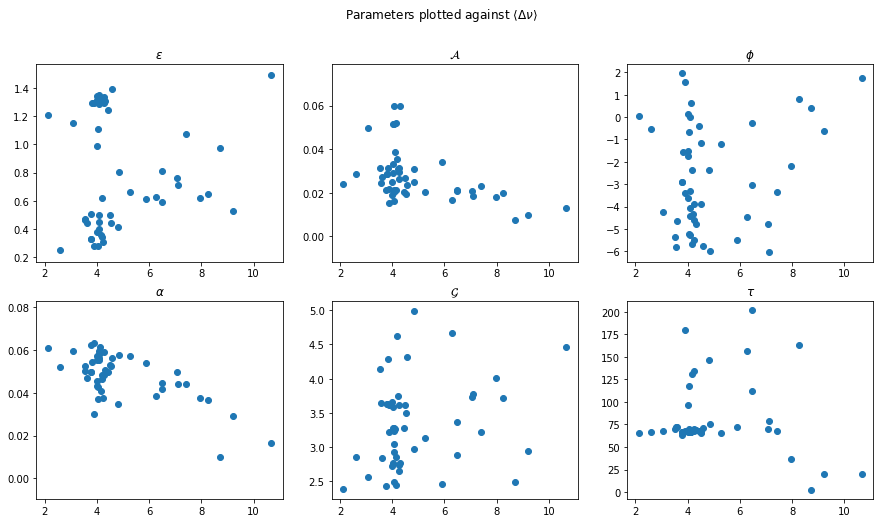

In [31]:
dnus = []
epsilons = []
alphas = []
As = []
Gs = []
phis = []
taus = []
for i in IDs:
    dnus.append(fits[str(i)]['dnu'].mean())
    epsilons.append(fits[str(i)]['epsilon'].mean())
    alphas.append(fits[str(i)]['alpha'].mean())
    As.append(fits[str(i)]['A'].mean())
    Gs.append(fits[str(i)]['G'].mean())
    phis.append(fits[str(i)]['phi'].mean())
    taus.append(fits[str(i)]['tau'].mean())
    
fig, axs = plt.subplots(2, 3, figsize=(15, 8), sharey=False, sharex=False)
axs[0,0].scatter(dnus, epsilons)
axs[0,0].set_title(r'$\epsilon$')
axs[1,0].scatter(dnus, alphas)
axs[1,0].set_title(r'$\alpha$')
axs[0,1].scatter(dnus, As)
axs[0,1].set_title(r'$\mathcal{A}$')
axs[1,1].scatter(dnus, Gs)
axs[1,1].set_title(r'$\mathcal{G}$')
axs[0,2].scatter(dnus, phis)
axs[0,2].set_title(r'$\phi$')
axs[1,2].scatter(dnus, taus)
axs[1,2].set_title(r'$\tau$')
fig.suptitle(r'Parameters plotted against $\langle \Delta \nu \rangle$')

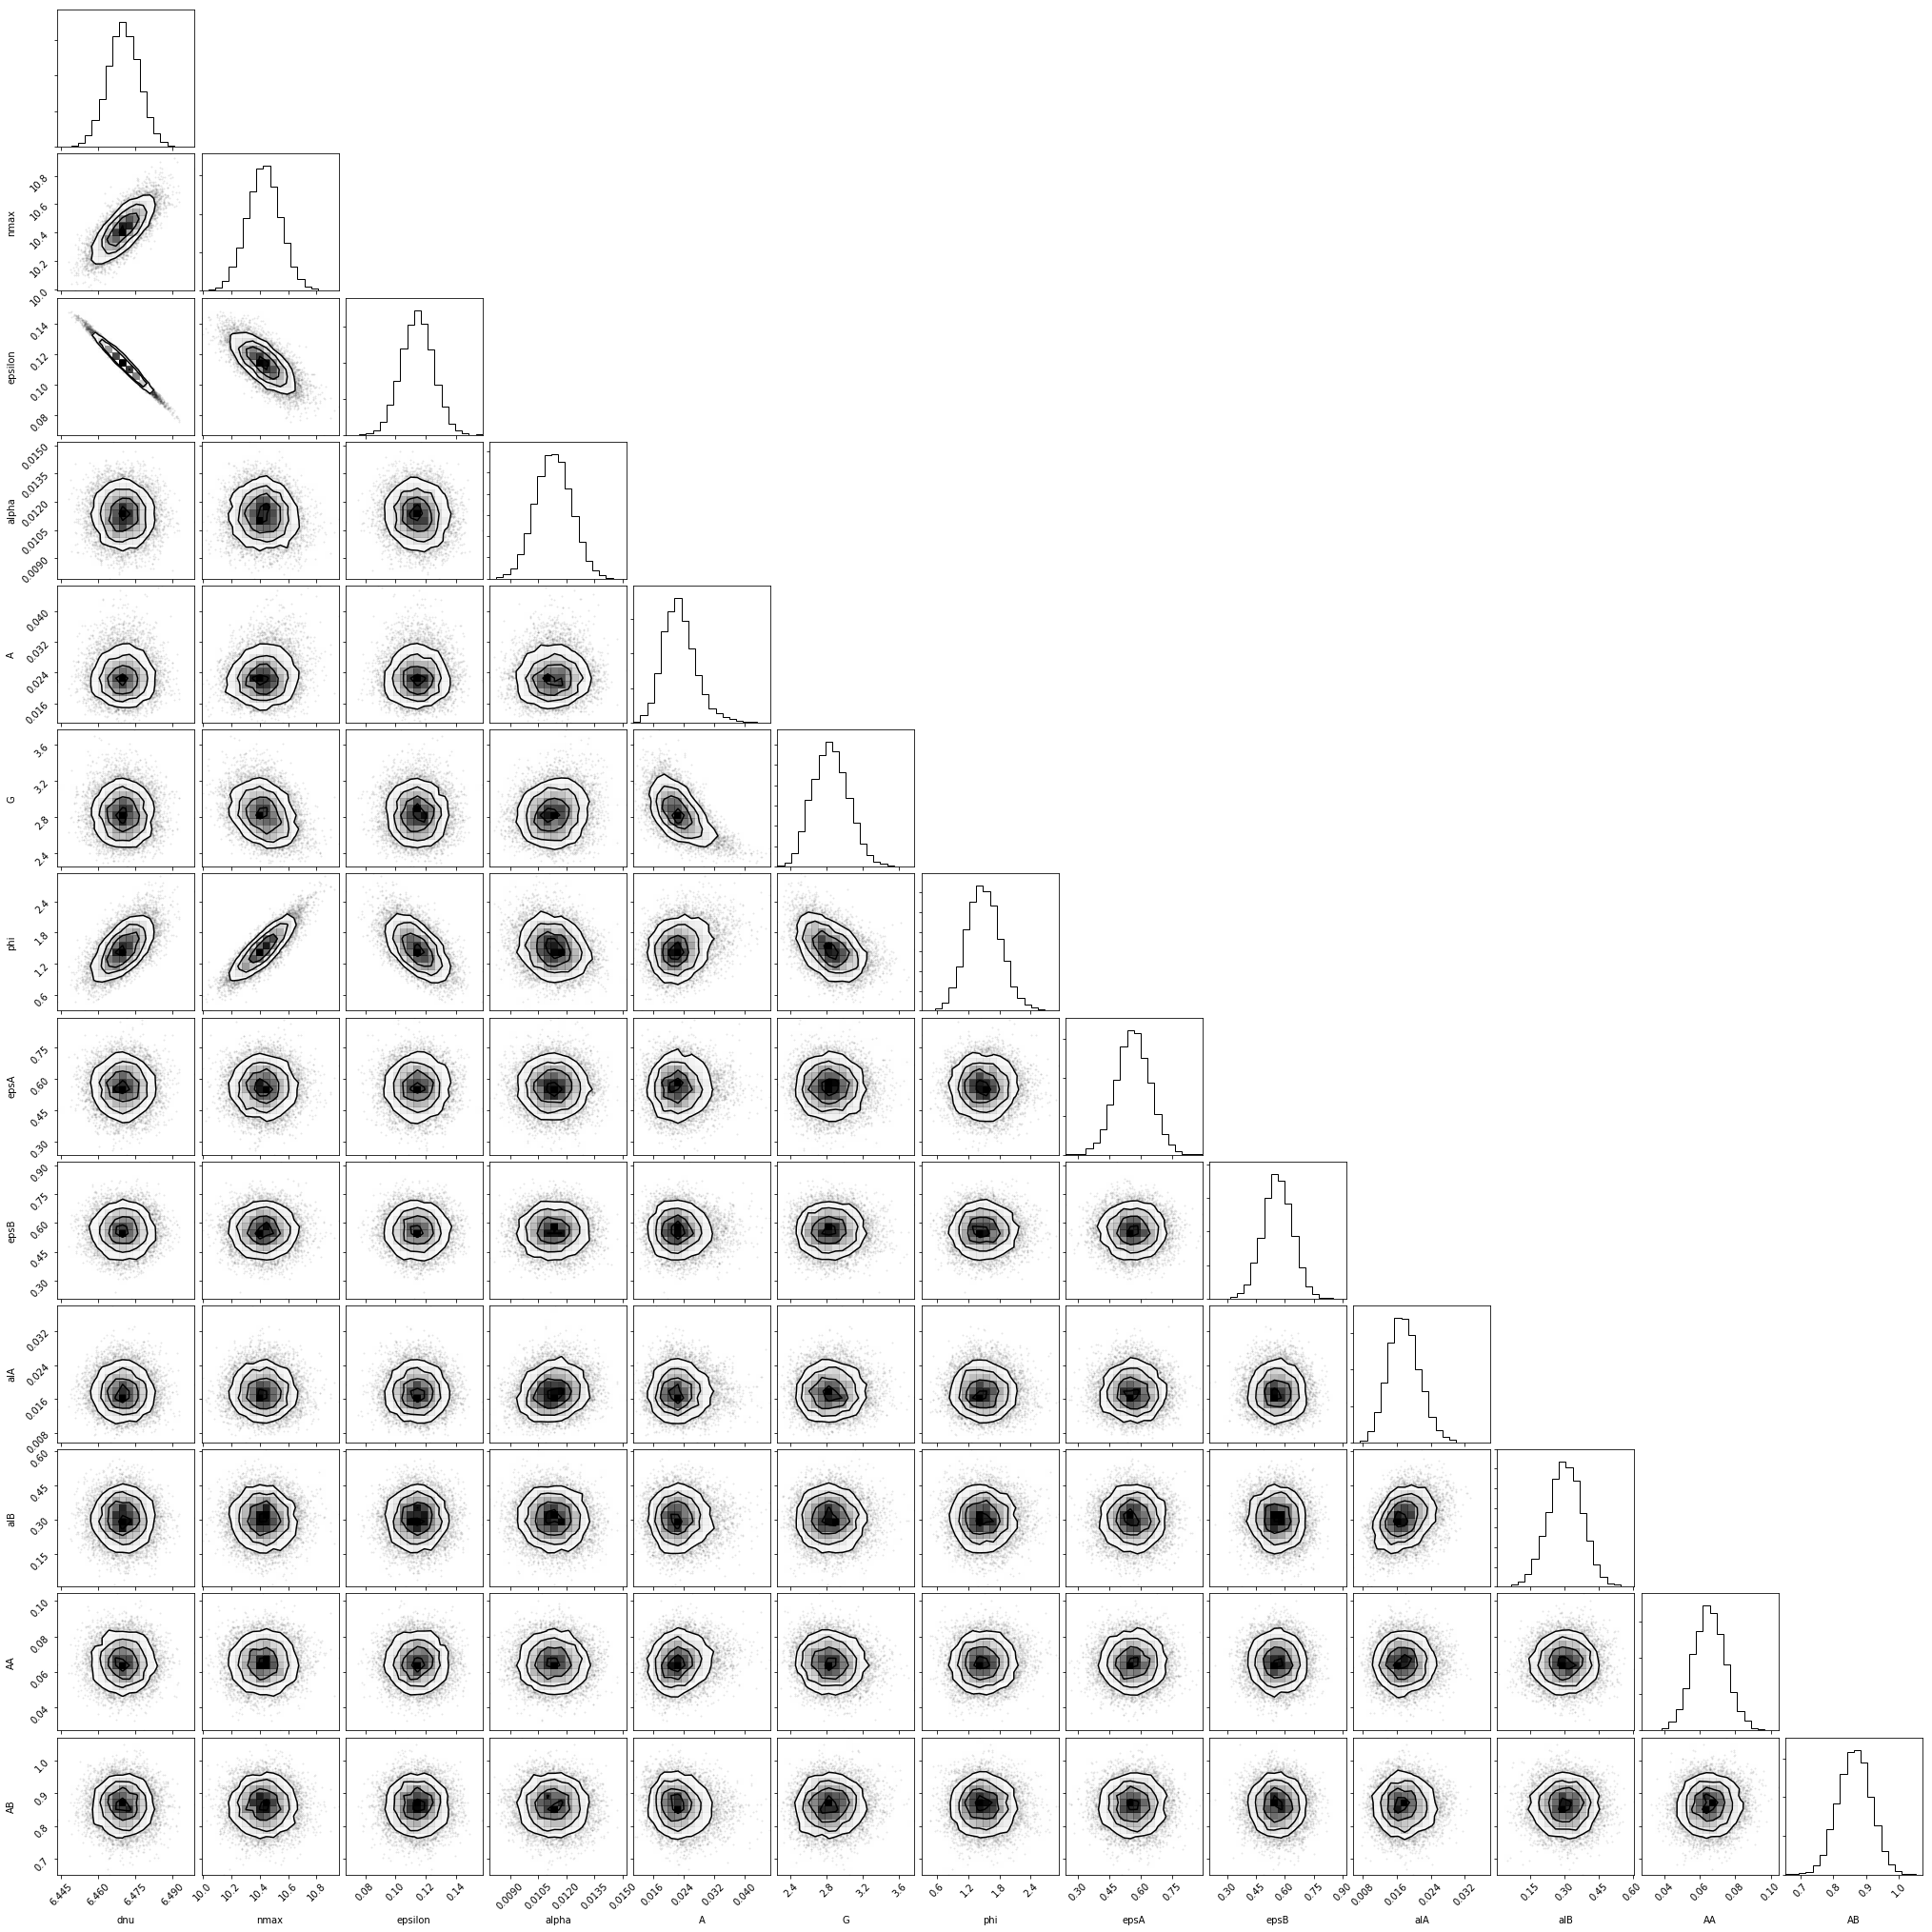

In [12]:
import corner
data = np.vstack([fit['dnu'], fit['nmax'], fit['epsilon'], fit['alpha'], fit['A'], fit['G'], fit['phi'], 
                fit['epsA'], fit['epsB'], fit['alA'], fit['alB'], fit['AA'], fit['AB']]).T
corner.corner(data, labels=['dnu', 'nmax', 'epsilon', 'alpha', 'A', 'G', 'phi', 'epsA', 'epsB', 'alA', 'alB', 'AA', 'AB'])
plt.show()